---

---

# Proyecto. Sprint 13: Pronósticos y predicciones 

## Descripción del proyecto

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

## Tienes que:

- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
- Analizar los factores que más impactan la pérdida.
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    - identificar a los grupos objetivo;
    - sugerir medidas para reducir la rotación;
    - describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## Instrucciones para completar el proyecto

### Paso 1. Descargar los datos

Model Fitness te aportó archivos CSV que contienen los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos:

- 'Churn' — la cancelación para el mes en cuestión
- Campos de dataset actuales:
- Datos del usuario del mes anterior
    - 'gender'.
    - 'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
    - 'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
    - Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
    - 'Phone' — si el/la usuario/a aportó el número de teléfono.
    - 'Age'.
    - 'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:
    - 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.
    - 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.
    - 'Group_visits' — si el/la usuario/a participa en sesiones grupales.
    - 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.
    - 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.
    - 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

In [2]:
# Cargar el dataset
file_path = "/datasets/gym_churn_us.csv"
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Paso 2. Llevar a cabo el análisis exploratorio de datos (EDA)
- Observa el dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar (utiliza el método describe()).
- Observa los valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron (utiliza el método groupby()).
- Traza histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.
- Crea una matriz de correlación y muéstrala.

In [5]:
# Verificar valores ausentes
missing_values = df.isnull().sum()
print("Valores ausentes en cada columna:\n", missing_values)

Valores ausentes en cada columna:
 gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


No hay valores ausentes

In [6]:
# Obtener estadísticas descriptivas
describe_stats = df.describe()
print("\nEstadísticas descriptivas:\n", describe_stats)


Estadísticas descriptivas:
             gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%

In [7]:
# Comparar valores medios por grupo de cancelación
grouped_means = df.groupby("Churn").mean()
print("\nValores medios por grupo de cancelación:\n", grouped_means)


Valores medios por grupo de cancelación:
          gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                              

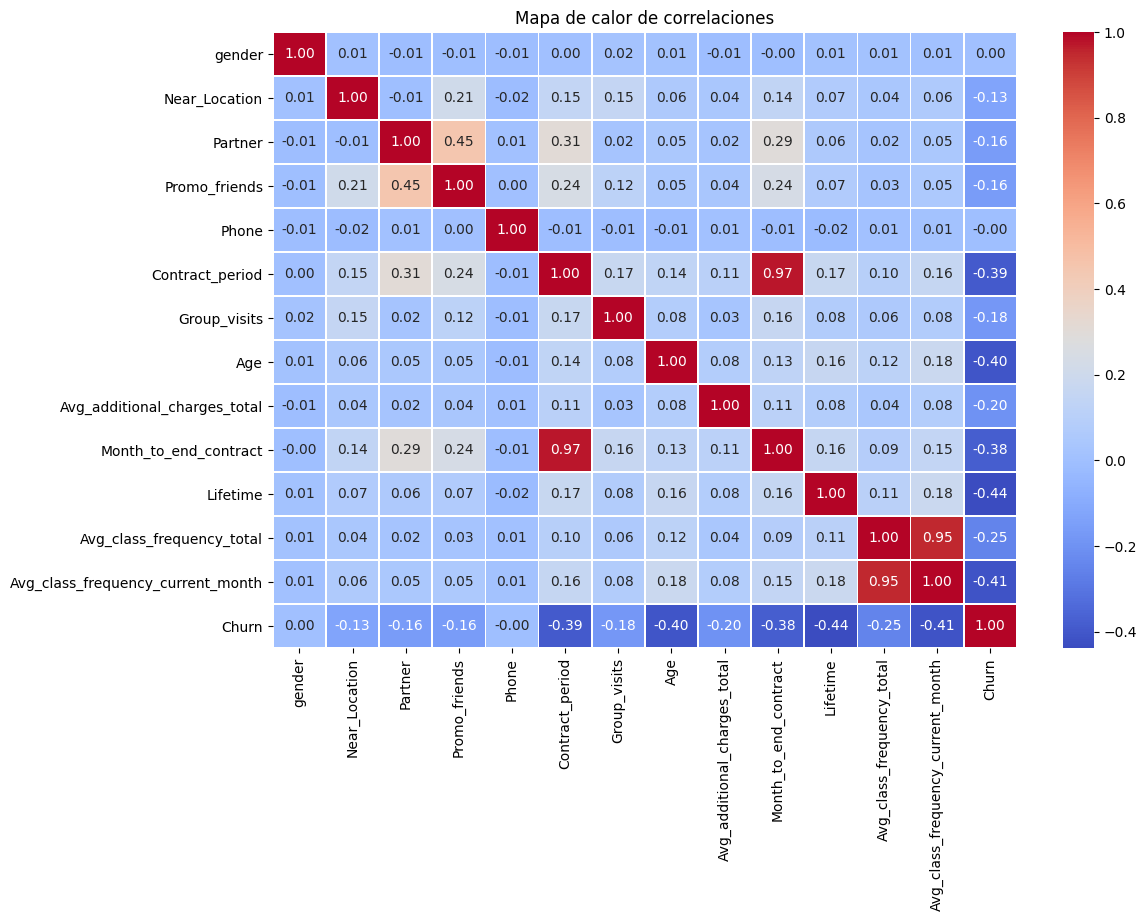

In [8]:
# Configuración de estilo
df_corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Mapa de calor de correlaciones")
plt.show()

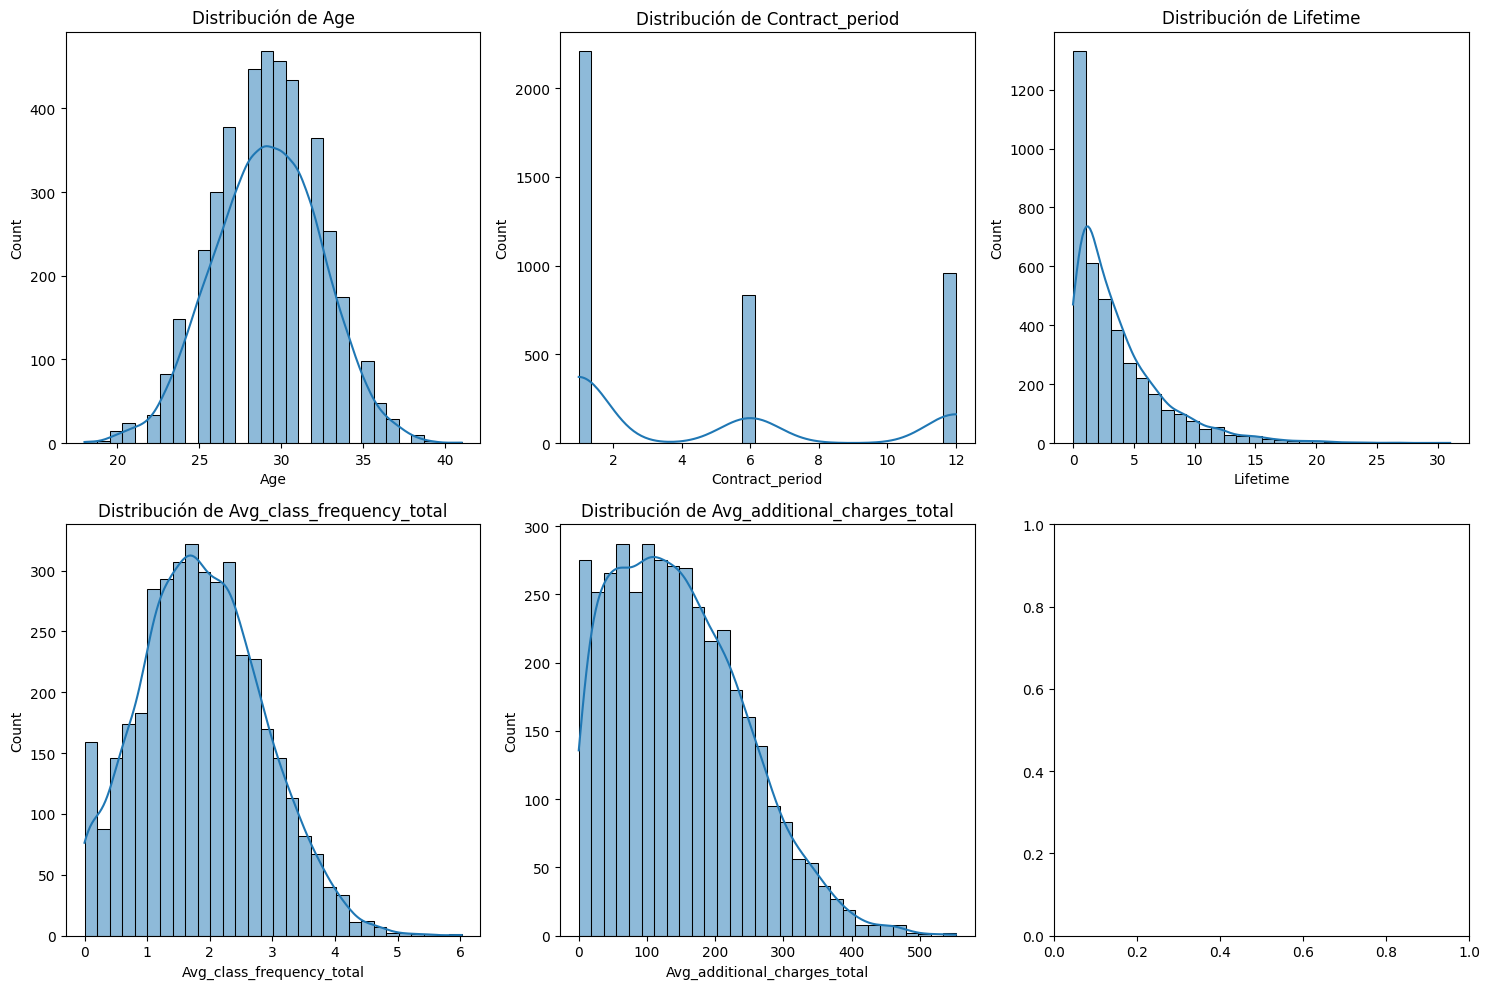

In [9]:
# Histogramas de variables clave
variables = ['Age', 'Contract_period', 'Lifetime', 'Avg_class_frequency_total', 'Avg_additional_charges_total']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {var}")

plt.tight_layout()
plt.show()

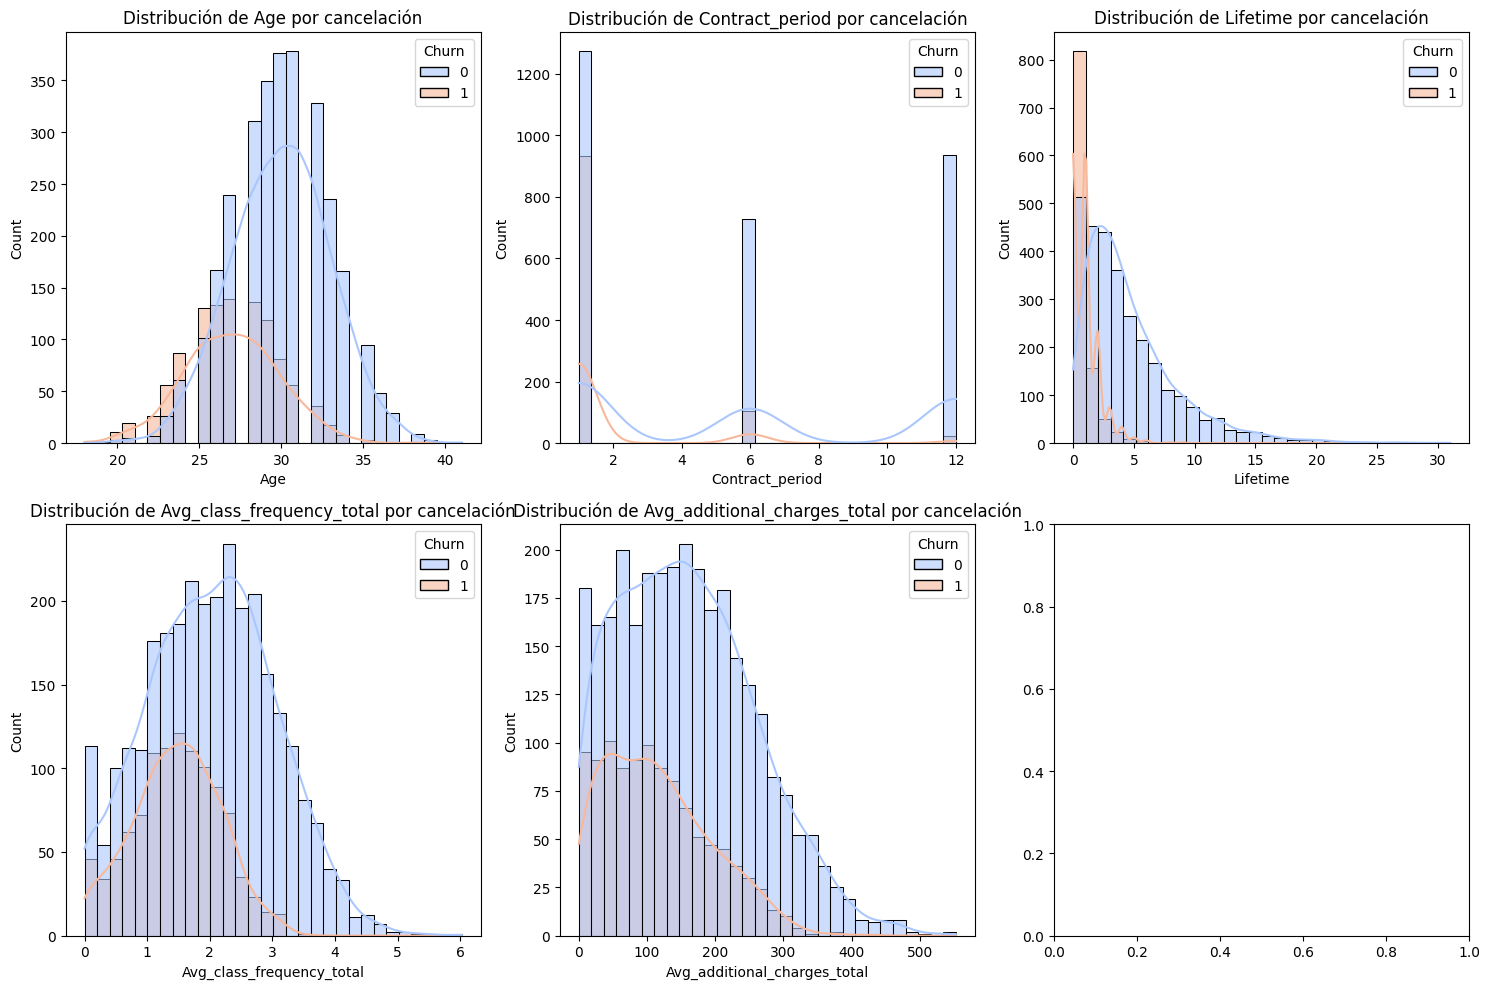

In [10]:
# Histogramas de distribución para clientes que se quedaron y los que cancelaron
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(data=df, x=var, hue="Churn", bins=30, kde=True, ax=axes[i], palette="coolwarm", alpha=0.6)
    axes[i].set_title(f"Distribución de {var} por cancelación")

plt.tight_layout()
plt.show()


##### Observaciones

De acuerdo a los valores promedio y la desviación estándar de las principales variables:
- Edad: Promedio de 29.18 años, con una desviación estándar de 3.26 años (rango: 18-41 años).
- Duración del contrato: Promedio de 4.68 meses, con una desviación estándar de 4.54 meses.
- Tiempo restante en el contrato: Promedio de 4.32 meses, con una desviación estándar de 4.19 meses.
- Tiempo total como cliente: Promedio de 3.72 meses, con una desviación estándar de 3.75 meses.
- Frecuencia de asistencia (total): Promedio de 1.88 visitas por unidad de tiempo, con una desviación estándar de 0.97.
- Frecuencia de asistencia (último mes): Promedio de 1.76 visitas, con una desviación estándar de 1.05.
- Gastos adicionales: Promedio de 146.94, con una desviación estandar de 96.35 (rango: 0.15 - 552.59).
- Clientes que cancelaron (Churn): El 26.5% de los clientes se han ido.


La mayoría de los contratos son cortos (mediana de 1 mes).

Hay clientes con 0 visitas en el último mes, lo que puede indicar señales tempranas de pérdida.

Los clientes que cancelaron:
- Tenían contratos significativamente más cortos (~4 meses menos).
- Llevaban menos tiempo en el gimnasio (~3.7 meses menos).
- Eran más jóvenes (~3 años en promedio).
- Asistían con menor frecuencia (~1 visita menos en el último mes).

Estos factores pueden ayudar a identificar clientes en riesgo y tomar acciones para mejorar la retención. 

### Paso 3. Construir un modelo para predecir la cancelación de usuarios

Crea un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria el mes siguiente.

- Divide los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split().
- Entrena el modelo en el set de entrenamiento con dos métodos:
    - regresión logística;
    - bosque aleatorio.
- Evalúa la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Utilízalos para comparar los modelos. ¿Qué modelo dio mejores resultados?

Recuerda indicar el parámetro random_state cuando dividas los datos y definas el algoritmo

In [11]:
# Preparación de datos para el modelo de clasificación
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Estandarización de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [13]:
# Modelo de clasificación: Regresión Logística
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\nEvaluación del modelo de Regresión Logística:")
print("Precisión:", accuracy_score(y_test, y_pred_log))
print("Precisión (Precision Score):", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_log))


Evaluación del modelo de Regresión Logística:
Precisión: 0.91625
Precisión (Precision Score): 0.8729281767955801
Recall: 0.7821782178217822
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       598
           1       0.87      0.78      0.83       202

    accuracy                           0.92       800
   macro avg       0.90      0.87      0.89       800
weighted avg       0.91      0.92      0.91       800



In [14]:
# Modelo de clasificación: Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

print("\nEvaluación del modelo de Random Forest:")
print("Precisión:", accuracy_score(y_test, y_pred_rf))
print("Precisión (Precision Score):", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred_rf))


Evaluación del modelo de Random Forest:
Precisión: 0.91
Precisión (Precision Score): 0.8494623655913979
Recall: 0.7821782178217822
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       598
           1       0.85      0.78      0.81       202

    accuracy                           0.91       800
   macro avg       0.89      0.87      0.88       800
weighted avg       0.91      0.91      0.91       800



### Paso 4. Crear clústeres de usuarios/as

Deja de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios/as):

- Estandariza los datos.
- Utiliza la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Nota: ¡renderizar el dendrograma puede llevar tiempo! Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.
- Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes. (Deja que el número de clústeres sea n=5 para que sea más sencillo comparar los resultados con los del resto del estudiantado. Sin embargo, en la vida real, nadie te dará tales pistas, así que tendrás que decidir basándote en el gráfico del paso anterior.)
- Mira los valores medios de característica para los clústeres.¿Hay algo que te llame la atención?
- Traza distribuciones de características para los clústeres. ¿Notas algo?
- Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

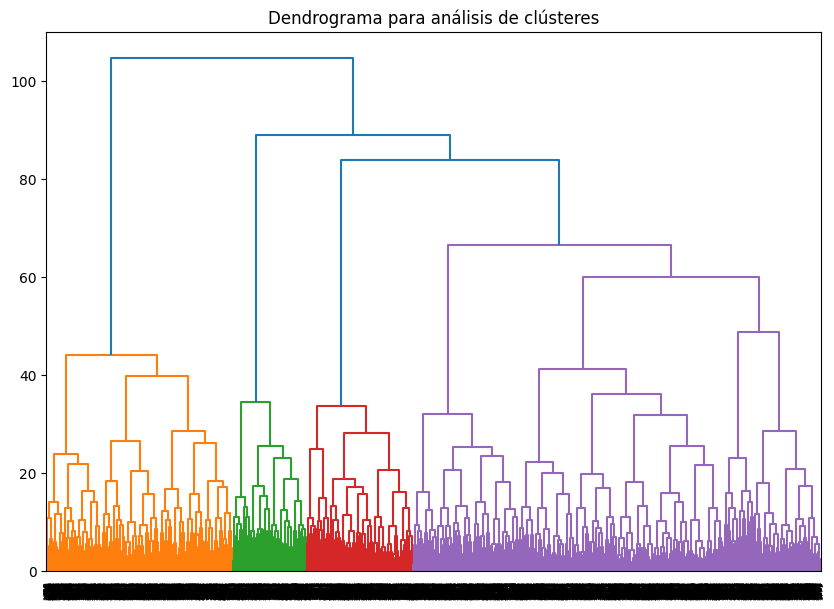

In [15]:
# Clustering: Crear dendrograma
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title("Dendrograma para análisis de clústeres")
plt.show()

In [16]:
# Clustering: K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [17]:
# Valores medios de características por clúster
cluster_means = df.groupby('Cluster').mean()
print("\nValores medios por clúster:\n", cluster_means)


Valores medios por clúster:
            gender  Near_Location   Partner  Promo_friends  Phone  \
Cluster                                                            
0        0.502370       0.949447  0.829384       0.998420    1.0   
1        0.554556       0.849269  0.263217       0.052868    1.0   
2        0.499422       0.937572  0.737572       0.478613    1.0   
3        0.485738       0.718011  0.299919       0.018745    1.0   
4        0.523316       0.862694  0.471503       0.305699    0.0   

         Contract_period  Group_visits        Age  \
Cluster                                             
0               3.097946      0.448657  29.104265   
1               2.606299      0.436445  30.008999   
2              11.854335      0.546821  29.905202   
3               1.914425      0.276284  28.083945   
4               4.777202      0.427461  29.297927   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
Cluster                                        

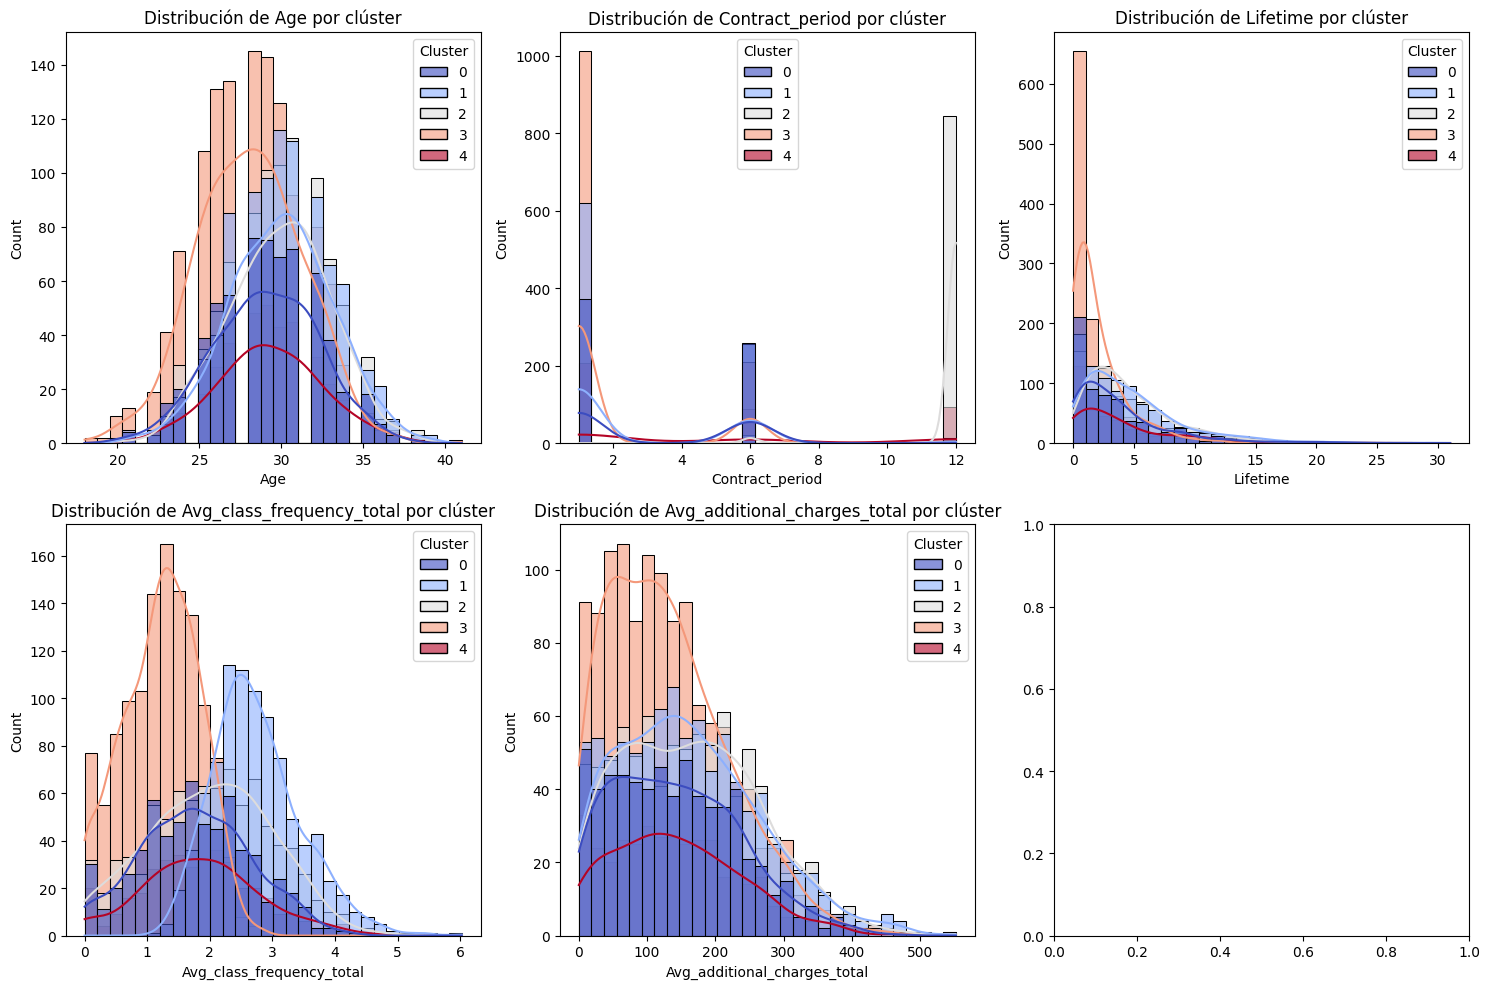

In [18]:
# Visualización de distribuciones por clúster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.histplot(data=df, x=var, hue="Cluster", bins=30, kde=True, ax=axes[i], palette="coolwarm", alpha=0.6)
    axes[i].set_title(f"Distribución de {var} por clúster")

plt.tight_layout()
plt.show()


In [19]:
# Tasa de cancelación por clúster
cluster_churn_rates = df.groupby('Cluster')['Churn'].mean()
print("\nTasa de cancelación por clúster:\n", cluster_churn_rates)


Tasa de cancelación por clúster:
 Cluster
0    0.246445
1    0.089989
2    0.021965
3    0.572942
4    0.266839
Name: Churn, dtype: float64


## Conclusiones 

Conclusiones:
1. Segmentación de clientes: Se identificaron cinco clústeres de clientes con diferentes patrones de uso del gimnasio. Algunos grupos presentan mayor riesgo de cancelación que otros.


2.  Factores clave en la cancelación: La duración del contrato, la frecuencia de visitas y el gasto en servicios adicionales son factores determinantes en la retención.


3.  Estrategia de personalización: Los clientes con baja frecuencia de visitas y contratos cortos tienen mayor propensión a cancelar, lo que sugiere la necesidad de estrategias específicas para ellos.


4.  Eficiencia del modelo predictivo: El modelo de Random Forest presentó mejor desempeño en la predicción de cancelaciones que la regresión logística, lo que indica que múltiples factores interactúan para determinar la pérdida de clientes.


Recomendaciones:

1. Ofertas personalizadas para clientes en riesgo

    - Enviar recordatorios y promociones específicas a clientes con baja frecuencia de visitas.
    - Ofrecer descuentos en renovación a clientes con contratos cortos para incentivarlos a permanecer.


2. Mejorar la experiencia del cliente

    - Introducir entrenamientos personalizados o clases grupales gratuitas para clientes en riesgo.
    - Brindar recompensas por asistencia regular, como acceso a beneficios exclusivos.


3. Optimización de precios y paquetes

    - Crear planes de membresía flexibles con opciones de pago mensual y anual ajustadas a cada tipo de cliente.
    - Ofrecer paquetes que incluyan servicios adicionales, como nutrición o entrenamiento personalizado, para aumentar el compromiso.


4. Campañas de retención basadas en datos

    - Implementar un sistema automatizado que envíe alertas cuando un cliente disminuya su asistencia.
    - Realizar encuestas para comprender mejor las razones de cancelación y ajustar la oferta de servicios.

Estas estrategias pueden ayudar a Model Fitness a reducir la tasa de cancelación y mejorar la fidelización de sus clientes. 